# MLflow

[MLflow](https://mlflow.org/docs/latest/concepts.html) seeks to address these three core issues:

* It’s difficult to keep track of experiments
* It’s difficult to reproduce code
* There’s no standard way to package and deploy models

In the past, when examining a problem, you would have to manually keep track of the many models you created, as well as their associated parameters and metrics. This can quickly become tedious and take up valuable time, which is where MLflow comes in.

MLflow is pre-installed on the Databricks Runtime for ML.

## ![Spark Logo Tiny](https://files.training.databricks.com/images/105/logo_spark_tiny.png) In this lesson you:<br>
* Use MLflow to track experiments, log metrics, and compare runs

-sandbox
<div><img src="https://files.training.databricks.com/images/eLearning/ML-Part-4/mlflow-tracking.png" style="height: 400px; margin: 20px"/></div>

In [0]:
import os
#import mlflow
#mlflow.autolog(disable=True)

### Setting the default database and user name  
##### Substitute "renato" by your name in the `username` variable.

In [0]:
## Put your name here
username = "renato"

dbutils.widgets.text("username", username)
spark.sql(f"CREATE DATABASE IF NOT EXISTS dsacademy_embedded_wave3_{username}")
spark.sql(f"USE dsacademy_embedded_wave3_{username}")
spark.conf.set("spark.sql.shuffle.partitions", 40)

spark.sql("SET spark.databricks.delta.formatCheck.enabled = false")
spark.sql("SET spark.databricks.delta.properties.defaults.autoOptimize.optimizeWrite = true")

Out[20]: DataFrame[key: string, value: string]

### Reading Dataset

Let's start by loading in our SF Airbnb Dataset.

In [0]:
deltaPath = os.path.join("/", "tmp", username)    #If we were writing to the root folder and not to the DBFS
if not os.path.exists(deltaPath):
    os.mkdir(deltaPath)
    
print(deltaPath)

airbnbDF = spark.read.format("delta").load(deltaPath)

/tmp/renato


In [0]:
(trainDF, testDF) = airbnbDF.randomSplit([.8, .2], seed=42)
print(trainDF.cache().count())

9504


### MLflow Tracking

MLflow Tracking is a logging API specific for machine learning and agnostic to libraries and environments that do the training.  It is organized around the concept of **runs**, which are executions of data science code.  Runs are aggregated into **experiments** where many runs can be a part of a given experiment and an MLflow server can host many experiments.

You can use [mlflow.set_experiment()](https://mlflow.org/docs/latest/python_api/mlflow.html#mlflow.set_experiment) to set an experiment, but if you do not specify an experiment, it will automatically be scoped to this notebook.

### Track Runs

Each run can record the following information:<br><br>

- **Parameters:** Key-value pairs of input parameters such as the number of trees in a random forest model
- **Metrics:** Evaluation metrics such as RMSE or Area Under the ROC Curve
- **Artifacts:** Arbitrary output files in any format.  This can include images, pickled models, and data files
- **Source:** The code that originally ran the experiment

**NOTE**: For Spark models, MLflow can only log PipelineModels.

In [0]:
import mlflow
import mlflow.spark
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

with mlflow.start_run(run_name="LR-Single-Feature") as run:
  # Define pipeline
  vecAssembler = VectorAssembler(inputCols=["bedrooms"], outputCol="features")
  lr = LinearRegression(featuresCol="features", labelCol="price")
  pipeline = Pipeline(stages=[vecAssembler, lr])
  pipelineModel = pipeline.fit(trainDF)
  
  # Log parameters
  mlflow.log_param("label", "price-bedrooms")
  
  # Log model
  mlflow.spark.log_model(pipelineModel, "model")
  
  # Evaluate predictions
  predDF = pipelineModel.transform(testDF)
  regressionEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="price", metricName="rmse")
  rmse = regressionEvaluator.evaluate(predDF)
  
  # Log metrics
  mlflow.log_metric("rmse", rmse)

There, all done! Let's go through the other two linear regression models and then compare our runs. 

**Question**: Does anyone remember the RMSE of the other runs?

Next let's build our linear regression model but use all of our features.

In [0]:
from pyspark.ml.feature import RFormula
with mlflow.start_run(run_name="LR-All-Features") as run:
  # Create pipeline
  rFormula = RFormula(formula="price ~ .", featuresCol="features", labelCol="price", handleInvalid="skip")
  lr = LinearRegression(labelCol="price", featuresCol="features")
  pipeline = Pipeline(stages = [rFormula, lr])
  pipelineModel = pipeline.fit(trainDF)
  
  # Log pipeline
  mlflow.spark.log_model(pipelineModel, "model")
  
  # Log parameter
  mlflow.log_param("label", "price-all-features")
  
  # Create predictions and metrics
  predDF = pipelineModel.transform(testDF)
  regressionEvaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction")
  rmse = regressionEvaluator.setMetricName("rmse").evaluate(predDF)
  r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
  
  # Log both metrics
  mlflow.log_metric("rmse", rmse)
  mlflow.log_metric("r2", r2)

Finally, we will use Linear Regression to predict the log of the price, due to its log normal distribution.

We'll also practice logging artifacts to keep a visual of our log normal histogram.

<Figure size 432x288 with 0 Axes>

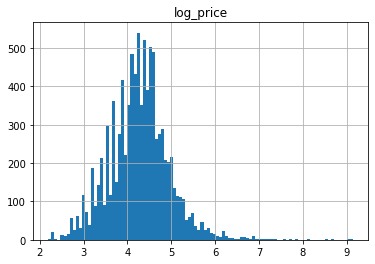

---------------------------------------------------------------------------
FileNotFoundError                         Traceback (most recent call last)
/databricks/python/lib/python3.9/site-packages/mlflow/store/artifact/databricks_artifact_repo.py in _signed_url_upload_file(self, credentials, local_file)
    238             # Putting an empty file in a request by reading file bytes gives 501 error.
--> 239             if os.stat(local_file).st_size == 0:
    240                 with rest_utils.cloud_storage_http_request(

FileNotFoundError: [Errno 2] No such file or directory: 'renatologNormal.png'

During handling of the above exception, another exception occurred:

MlflowException                           Traceback (most recent call last)
<command-74902913649282> in <cell line: 5>()
     37   figPath = username + "logNormal.png"
     38   #plt.savefig(figPath)
---> 39   mlflow.log_artifact(figPath)
     40   plt.show()

/databricks/python/lib/python3.9/site-packages/mlflow/tracking

In [0]:
from pyspark.ml.feature import RFormula
from pyspark.sql.functions import col, log, exp
import matplotlib.pyplot as plt

with mlflow.start_run(run_name="LR-Log-Price") as run:
  # Take log of price
  logTrainDF = trainDF.withColumn("log_price", log(col("price")))
  logTestDF = testDF.withColumn("log_price", log(col("price")))
  
  # Log parameter
  mlflow.log_param("label", "log-price")
  
  # Create pipeline
  rFormula = RFormula(formula="log_price ~ . - price", featuresCol="features", labelCol="log_price", handleInvalid="skip")  
  lr = LinearRegression(labelCol="log_price", predictionCol="log_prediction")
  pipeline = Pipeline(stages = [rFormula, lr])
  pipelineModel = pipeline.fit(logTrainDF)
  
  # Log model
  mlflow.spark.log_model(pipelineModel, "log-model")
  
  # Make predictions
  predDF = pipelineModel.transform(logTestDF)
  expDF = predDF.withColumn("prediction", exp(col("log_prediction")))
  
  # Evaluate predictions
  rmse = regressionEvaluator.setMetricName("rmse").evaluate(expDF)
  r2 = regressionEvaluator.setMetricName("r2").evaluate(expDF)
  
  # Log metrics
  mlflow.log_metric("rmse", rmse)
  mlflow.log_metric("r2", r2)
  
  # Log artifact
  plt.clf()
  logTrainDF.toPandas().hist(column="log_price", bins=100)
  figPath = username + "logNormal.png" 
  #plt.savefig(figPath)
  mlflow.log_artifact(figPath)
  plt.show()

That's it! Now, let's use MLflow to easily look over our work and compare model performance. You can either query past runs programmatically or use the MLflow UI.

### Querying Past Runs

You can query past runs programmatically in order to use this data back in Python.  The pathway to doing this is an `MlflowClient` object.

In [0]:
from mlflow.tracking import MlflowClient

client = MlflowClient()

In [0]:
client.list_experiments()

You can also use [search_runs](https://mlflow.org/docs/latest/search-syntax.html) to find all runs for a given experiment.

In [0]:
experiment_id = run.info.experiment_id
runs_df = mlflow.search_runs(experiment_id)

display(runs_df)

Pull the last run and look at metrics.

In [0]:
runs = client.search_runs(experiment_id, order_by=["attributes.start_time desc"], max_results=1)
runs[0].data.metrics

In [0]:
run_id = runs[0].info.run_id
run_id

Examine the results in the UI.  Look for the following:<br><br>

1. The `Experiment ID`
2. The artifact location.  This is where the artifacts are stored in DBFS.
3. The time the run was executed.  **Click this to see more information on the run.**
4. The code that executed the run.


After clicking on the time of the run, take a look at the following:<br><br>

1. The Run ID will match what we printed above
2. The model that we saved, included a pickled version of the model as well as the Conda environment and the `MLmodel` file.

Note that you can add notes under the "Notes" tab to help keep track of important information about your models. 

Also, click on the run for the log normal distribution and see that the histogram is saved in "Artifacts".

### Load Saved Model

Let's practice [loading](https://www.mlflow.org/docs/latest/python_api/mlflow.spark.html) our logged log-normal model.

In [0]:
run_id = run.info.run_id

loaded_model = mlflow.spark.load_model(f"dbfs:/databricks/mlflow-tracking/{experiment_id}/{run_id}/artifacts/log-model")
display(loaded_model.transform(testDF))

## Additional Resources

**Q:** What is MLflow at a high level?  
**A:** <a href="https://databricks.com/session/accelerating-the-machine-learning-lifecycle-with-mlflow-1-0" target="_blank">Listen to Spark and MLflow creator Matei Zaharia's talk at Spark Summit in 2019.</a>

**Q:** Where can I find the MLflow docs?  
**A:** <a href="https://www.mlflow.org/docs/latest/index.html" target="_blank">You can find the docs here.</a>

Code modified and enhanced from 2020 Databricks, Inc. All rights reserved.<br/>
Apache, Apache Spark, Spark and the Spark logo are trademarks of the <a href="http://www.apache.org/">Apache Software Foundation</a>.<br/>
<br/>
<a href="https://databricks.com/privacy-policy">Privacy Policy</a> | <a href="https://databricks.com/terms-of-use">Terms of Use</a> | <a href="http://help.databricks.com/">Support</a>